# **Named Entity Recognition Using BI-LSTM**

In [1]:
'''
Named Entity Recognition using CRF model
In Natural Language Processing (NLP) an Entity Recognition is one of the common problem. The entity is referred to as the part of the text that is interested in. In NLP, NER is a method of extracting the relevant information from a large corpus and classifying those entities into predefined categories such as location, organization, name and so on. Information about lables:

geo = Geographical Entity

org = Organization

per = Person

gpe = Geopolitical Entity

tim = Time indicatorindicato

art = Artifact

eve = Event

nat = Natural Phenomenon

  1. Total Words Count = 1354149 
  2. Target Data Column: Tag

'''

'\nNamed Entity Recognition using CRF model\nIn Natural Language Processing (NLP) an Entity Recognition is one of the common problem. The entity is referred to as the part of the text that is interested in. In NLP, NER is a method of extracting the relevant information from a large corpus and classifying those entities into predefined categories such as location, organization, name and so on. Information about lables:\n\ngeo = Geographical Entity\n\norg = Organization\n\nper = Person\n\ngpe = Geopolitical Entity\n\ntim = Time indicatorindicato\n\nart = Artifact\n\neve = Event\n\nnat = Natural Phenomenon\n\n  1. Total Words Count = 1354149 \n  2. Target Data Column: Tag\n\n'

# **Initialization**

###   **Import Libraries**

In [2]:
#computing
import numpy as np
import pandas as pd

#visualisation and processing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

#model
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.layers import Bidirectional, TimeDistributed, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

#others
import warnings 
warnings.filterwarnings('ignore')


plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)

### **Reading Data**

In [4]:
#reading csv file
data = pd.read_csv('D:/keval/study/NER-Nlp/new_ner.csv',
                   encoding = 'latin1')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


Note that above CSV file is formed from an already tokenized in text form with
part of speech and tag. Note in case, we have only text then we can tokenize data using NLTK. 

The above has Null values but these are part of the same sentence. Hence, we will use `ffill`.

In [5]:
data.fillna(method = 'ffill', inplace = True)
data[:10]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
data.shape

(1048575, 4)

In [6]:
#sort tags with respect to their counts
tag_count  = data.Tag.value_counts()
tag_count = pd.DataFrame(tag_count)
tag_count.reset_index(inplace=True)

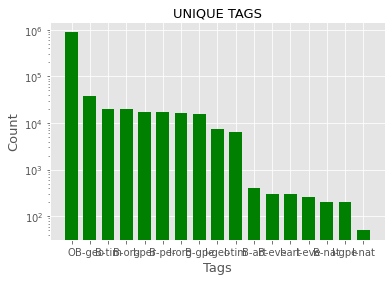

In [7]:
plt.bar(tag_count["index"],tag_count["Tag"], width=0.7, color ='green')
plt.title('UNIQUE TAGS', fontsize = 13)
plt.yscale("log")
plt.xlabel('Tags', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.show()

Note that the above has more O tags in data compared to other tags. In case BI-LSTM doesn't perform well then in that case we might need to rectify
this unbalanced data using appropriate sampling methods.

# **Processing**

In [9]:
words = list(set(data['Word'].values))
num_words = len(words)
tags = list(set(data['Tag'].values))
n_tags = len(tags)
print(f"The number of unique words in data: {num_words}\nThe number of unique tags in data: {n_tags}")
words
tags

The number of unique words in data: 35178
The number of unique tags in data: 17


['B-org',
 'I-nat',
 'B-eve',
 'I-art',
 'B-geo',
 'I-org',
 'B-nat',
 'I-eve',
 'B-per',
 'B-gpe',
 'I-gpe',
 'B-tim',
 'O',
 'B-art',
 'I-geo',
 'I-tim',
 'I-per']

In [10]:
# class Grouping:
Batching = lambda data: [ (wrd,tag) for wrd,tag in zip(data['Word'].values.tolist(),data['Tag'].values.tolist())]

batch = data.groupby('Sentence #').apply(Batching)
sentences = [i for i in batch]


In [11]:
print(*sentences[0], sep=" ")

('Thousands', 'O') ('of', 'O') ('demonstrators', 'O') ('have', 'O') ('marched', 'O') ('through', 'O') ('London', 'B-geo') ('to', 'O') ('protest', 'O') ('the', 'O') ('war', 'O') ('in', 'O') ('Iraq', 'B-geo') ('and', 'O') ('demand', 'O') ('the', 'O') ('withdrawal', 'O') ('of', 'O') ('British', 'B-gpe') ('troops', 'O') ('from', 'O') ('that', 'O') ('country', 'O') ('.', 'O')


### Mapping Words to Index.

Note that all models require inputs in real numbers. Therefore, we need to convert these words to tensors so that we can train models on this data. Here, we use a simple method where we assign each word and tag a unique number.

In [13]:
word2idx = {w : i + 1 for i, w in enumerate(words)}

tag2idx = {t : i for i, t in enumerate(tags)}


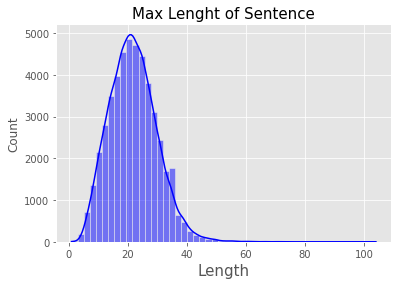

In [14]:
sns.histplot([len(s) for s in sentences], kde=True,color="blue", bins=50)
plt.title('Max Lenght of Sentence',fontsize = 15)
plt.xlabel('Length', fontsize = 15)
plt.show()

- HERE WE CAN SEE THAT THE MAX LENGTH REACHES 60

### Padding Words

Note that since sentence are variable length and these would create a problem
as the tensor would be not of proper shape. Hence, to compensate for this
we pad `X` with extra numbers.

In [15]:
max_len = 60
#Converting Sentences to vectors 
X = [[word2idx[w[0]] for w in s] for s in sentences]
y = [[tag2idx[t[1]] for t in s] for s in sentences]
vector_len = [len(vec) for vec in X]
print(*vector_len[:5], sep=",")


24,25,32,11,35


Observe that the vectors are of different length. And to address this issue we
pad vectors to make all of them of fixed length.

In [16]:
X = pad_sequences(X, maxlen = max_len, padding = 'post', value = num_words - 1)
y = pad_sequences(y, maxlen = max_len, padding = 'post', value = tag2idx['O'])

y = [to_categorical(i, num_classes = n_tags) for i in y]


In [17]:
vector_pad_len = [len(vec) for vec in X]
print(len(set(vector_pad_len)))

1


Note that after padding all are of same length. As maximum length of sentence in
our data is `60`

In [18]:
print(X)

[[ 5523  8005 24588 ... 35177 35177 35177]
 [19662 22699 12215 ... 35177 35177 35177]
 [13321 24193 22204 ... 35177 35177 35177]
 ...
 [ 1843 22152 16714 ... 35177 35177 35177]
 [27366 21383 20484 ... 35177 35177 35177]
 [29268 23009 17787 ... 35177 35177 35177]]


# **Training**

We will split training data into two parts. First dataset will be used for 
training purpose and the second dataset will be used for validation.

In [19]:
X_train, X_r, y_train, y_r = train_test_split(X, y, test_size = 0.3,
                                                    random_state = 44)
X_val, X_test, y_val, y_test = train_test_split(X_r, y_r, test_size = 0.5,
                                                    random_state = 44)

In [20]:
X_train.shape, X_val.shape, X_test.shape

((33571, 60), (7194, 60), (7194, 60))

### Model BI-LSTM:

In [21]:
input_dim = num_words + 1
output_dim = max_len
input_length = max_len

In [22]:
input_dim, output_dim, input_length
class bi_lstm:

  def __init__(self):
    self.model = Sequential()

    self.model.add(Embedding(input_dim = input_dim, output_dim = output_dim,
                        input_length = input_length))

    self.model.add(SpatialDropout1D(0.1))

    self.model.add(Bidirectional(LSTM(units = 100, recurrent_dropout = 0.1,
                                 return_sequences = True)))

    self.model.add(TimeDistributed(Dense(units = n_tags,
                                         activation = 'softmax')))

    self.model.compile(optimizer = 'adam',
                       loss = 'categorical_crossentropy',
                       metrics = ['accuracy'])
  def train(self,X_train,y_train, X_val, y_val):
      callbacks = EarlyStopping(monitor = 'accuracy',
                                patience = 2,
                                verbose = 1,
                                mode = 'max',
                                restore_best_weights = True)
      
      history = self.model.fit(X_train, np.array(y_train),
                          batch_size = 32, epochs = 10,
                          callbacks = callbacks, verbose = 1,
                          validation_data=(X_val, np.array(y_val)))
      return history

  def test(self,X_test,y_test):
      self.model.evaluate(X_test, np.array(y_test))  


In [23]:
model = bi_lstm()
model.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 60)            2110740   
                                                                 
 spatial_dropout1d (SpatialD  (None, 60, 60)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          128800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 60, 17)           3417      
 ibuted)                                                         
                                                                 
Total params: 2,242,957
Trainable params: 2,242,957
Non-trainable params: 0
______________________________________________

In [24]:
history = model.train(X_train,y_train,X_val,y_val)

Epoch 1/10
1050/1050 [==============================] - 74s 66ms/step - loss: 0.1588 - accuracy: 0.9646 - val_loss: 0.0564 - val_accuracy: 0.9837
Epoch 2/10
1050/1050 [==============================] - 76s 72ms/step - loss: 0.0430 - accuracy: 0.9874 - val_loss: 0.0429 - val_accuracy: 0.9872
Epoch 3/10
1050/1050 [==============================] - 91s 87ms/step - loss: 0.0308 - accuracy: 0.9907 - val_loss: 0.0411 - val_accuracy: 0.9876
Epoch 4/10
1050/1050 [==============================] - 86s 82ms/step - loss: 0.0250 - accuracy: 0.9922 - val_loss: 0.0417 - val_accuracy: 0.9876
Epoch 5/10
1050/1050 [==============================] - 88s 84ms/step - loss: 0.0213 - accuracy: 0.9932 - val_loss: 0.0428 - val_accuracy: 0.9877
Epoch 6/10
1050/1050 [==============================] - 91s 86ms/step - loss: 0.0187 - accuracy: 0.9940 - val_loss: 0.0453 - val_accuracy: 0.9875
Epoch 7/10
1050/1050 [==============================] - 91s 87ms/step - loss: 0.0165 - accuracy: 0.9946 - val_loss: 0.0484 -

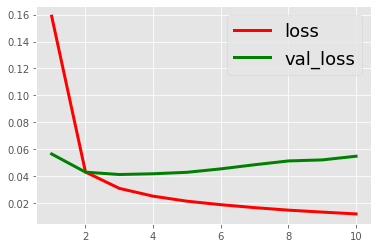

In [25]:
plt.plot([1,2,3,4,5,6,7,8,9,10], history.history['loss'],'r',linewidth=3.0)
plt.plot([1,2,3,4,5,6,7,8,9,10], history.history['val_loss'],'g',linewidth=3.0)
plt.legend(['loss', 'val_loss'],fontsize=18);
plt.savefig('val_and_loss_graph.png')

In [26]:
model.model.save('test.h5')

# TEST

In [29]:
i = np.random.randint(0,X_test.shape[0])
p = model.model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis =-1)
y_true = np.argmax(np.array(y_test), axis =-1)[i]
print("{:15}{:5}\t {} \n".format("Word","True","Pred"))
print("-"*30)
for w,true,pred in zip(X_test[i],y_true,p[0]):
    print("{:15}{}\t{}".format(words[w-1],tags[true],tags[pred]))

1/1 [==============================] - 0s 19ms/step
Word           True 	 Pred 

------------------------------
Polls          O	O
close          O	O
at             O	O
four           B-tim	B-tim
p.m.           I-tim	I-tim
and            O	O
results        O	O
are            O	O
expected       O	O
a              O	O
few            O	B-tim
hours          O	O
later          B-tim	B-tim
.              O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
nationalities  O	O
natio

In [ ]:



# record = pd.DataFrame(data)
# record

In [ ]:
# import pandas as pd
# import random as rn
# csv_main = pd.read_csv('/content/Department_Dataset.csv')
# csv_main
# state = ['Pune','Banglore','Mumbai']

# csv_main['ID'][csv_main.City=='Mumbai']

# queue = list(set(csv_main.queue.to_list()))
# ID = csv_main.ID.to_list()

# data = []
# ci_id = []
# m,p,b = 0,0,0
# def allocation(allocate):
#   for i in allocate.keys():

#     for i in range(allocate[i]):
#       ch,qu,st =  rn.choice(ID) , rn.choice(queue),rn.choice(state)
#       m+=1 if st == 'Mumbai' else  p += 1 if st == 'Pune' else b+=1 if st =='Banglore' else 0

      
      
      
#       while ch in ci_id :


#         ch,qu,st =  rn.choice(ID) , rn.choice(queue),rn.choice(state)
#       ci_id.append(ch)
#       state.remove('Mumbai') if m == 8 else state.remove('Pune') if p == 8 else state.remove('Banglore') if b == 8 else 0
#       data.append([ch,(csv_main['name'][csv_main['ID'] ==ch]).to_list()[0],qu,st])
#   print(m,p,b)
#   return data



# allocate = { 'pu':8, 'mum':8 ,'bg':8 }
# record = allocation(allocate)

# record

# record.to_csv('Result.csv',mode ='a',index= False)
    


# record = pd.DataFrame(data)
# record.to_csv('Result.csv',mode ='a',index= False)
    
